In [1]:
library('tidyverse')
library('Seurat')
library('patchwork')
library('ggrepel')

org_opts <- options()

exp_thold <- 0.5
exp_strict_thold <- 0.01
marker_genes <- c('CD3E', 'CD8A', 'CD4', 'IL15', 'CD14', 'S100B', 'PMEL', 'NCAM1', 'CD19')

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Attaching SeuratObject

Attaching sp



In [2]:
list.files('data')

[1] "OBS-006-001" "OBS-006-002" "OBS-006-003" "OBS-006-004" "OBS-006-005"
[6] "OBS-006-007"

In [3]:
read_scrna_res <- 
    function(sample_name) {
        sample_path <- paste('data', sample_name, 'filtered_feature_bc_matrix', sep='/')

        counts <-
            ReadMtx(
                mtx=paste(sample_path, 'matrix.mtx.gz', sep='/'),
                features=paste(sample_path, 'features.tsv.gz', sep='/'),
                cells=paste(sample_path, 'barcodes.tsv.gz', sep='/')
            )

        CreateSeuratObject(counts=counts, project=sample_name)

    }

In [4]:
system.time({

    obs_006 <-
        merge(
            read_scrna_res('OBS-006-001'),
            y=c(
                read_scrna_res('OBS-006-002'),
                read_scrna_res('OBS-006-003'),
                read_scrna_res('OBS-006-004'),
                read_scrna_res('OBS-006-005'),
                read_scrna_res('OBS-006-007')
            ),
            add.cell.ids=c('001', '002', '003', '004', '005', '007'),
            project='OBS-006'
        )
    
})

obs_006[["sample_name"]] <- Idents(obs_006)

   user  system elapsed 
280.660  47.084 344.567 

In [5]:
obs_006

An object of class Seurat 
19912 features across 132893 samples within 1 assay 
Active assay: RNA (19912 features, 0 variable features)

In [6]:
table(obs_006$orig.ident)


OBS-006-001 OBS-006-002 OBS-006-003 OBS-006-004 OBS-006-005 OBS-006-007 
      11503       33608       17948       24286       27749       17799 

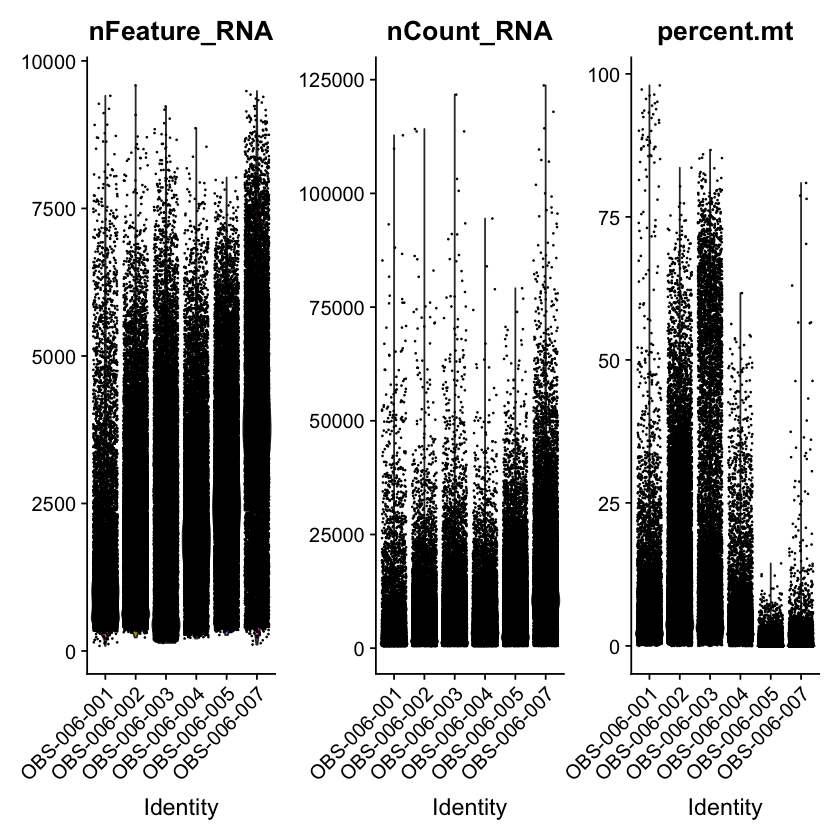

In [7]:
obs_006[["percent.mt"]] <-
    PercentageFeatureSet(obs_006, pattern="^MT-")

VlnPlot(obs_006, features=c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol=3)

In [8]:
feature_tbl <-
    obs_006 %>%
    FetchData(vars=c('nFeature_RNA', 'nCount_RNA', 'percent.mt')) %>%
    rownames_to_column('cell_id') %>%
    mutate(`sample_id`=str_replace(`cell_id`, '_.*', '')) %>%
    relocate(`sample_id`) %>%
    as_tibble()

feature_tbl %>%
    count(`sample_id`)

sample_id n    
1 001       11503
2 002       33608
3 003       17948
4 004       24286
5 005       27749
6 007       17799

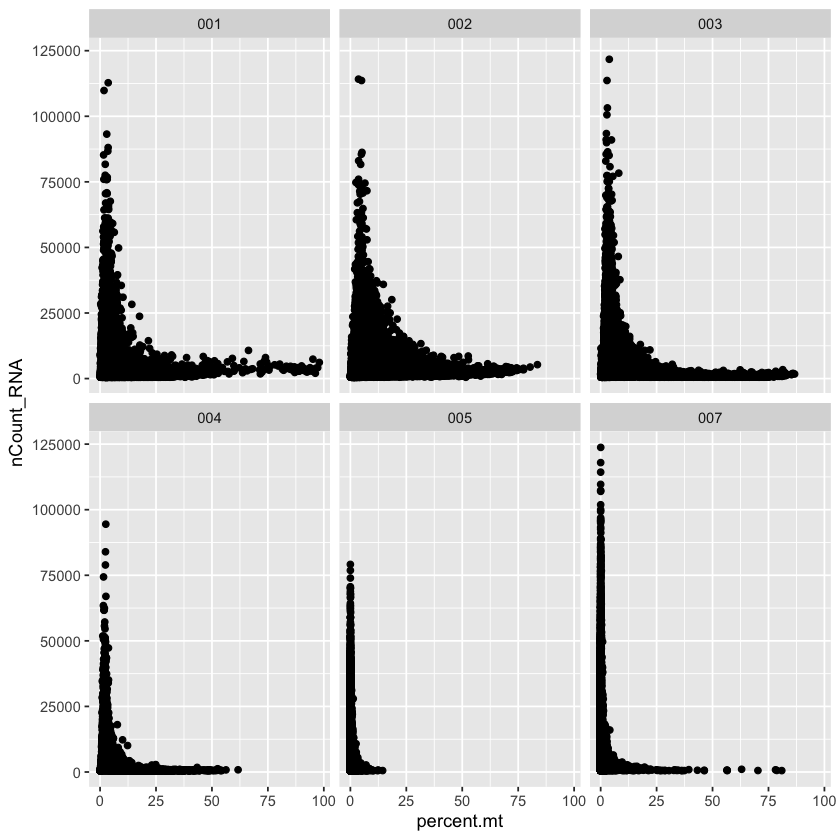

In [9]:
feature_tbl %>%
    ggplot(aes(x=`percent.mt`, y=`nCount_RNA`)) +
        geom_point() +
        facet_wrap(~`sample_id`)

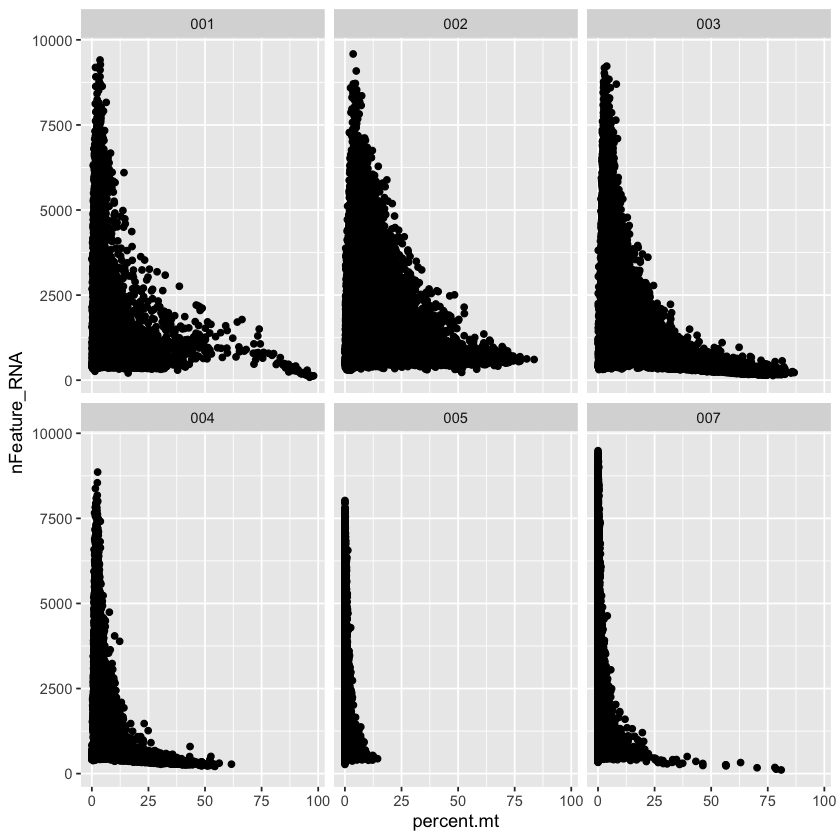

In [10]:
feature_tbl %>%
    ggplot(aes(x=`percent.mt`, y=`nFeature_RNA`)) +
        geom_point() +
        facet_wrap(~`sample_id`)

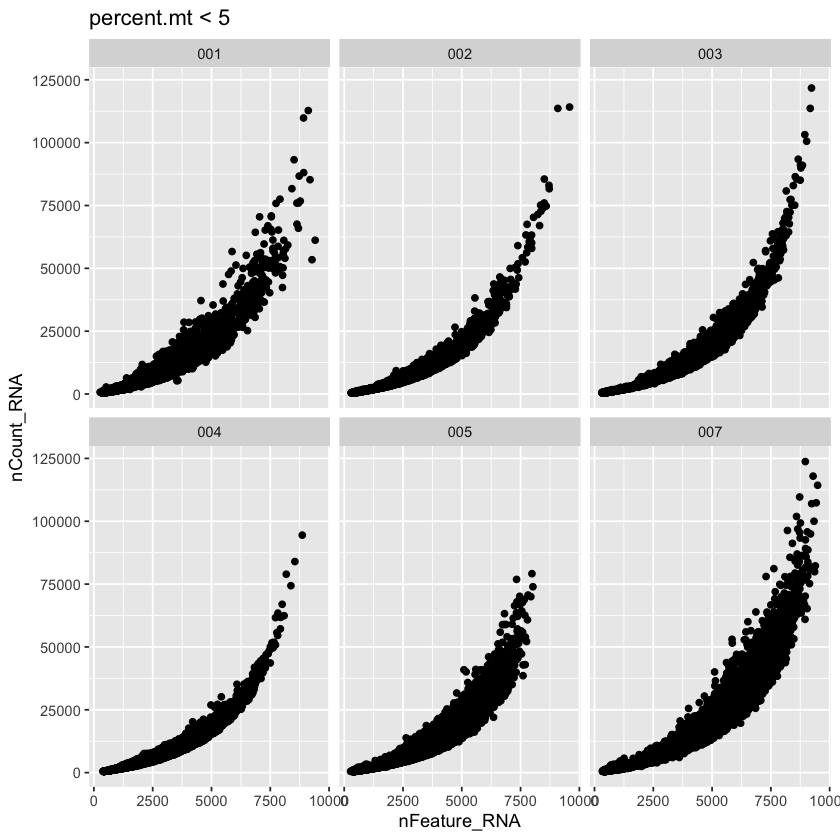

In [11]:
feature_tbl %>%
    filter(`percent.mt` < 5) %>%
    ggplot(aes(x=`nFeature_RNA`, y=`nCount_RNA`)) +
        geom_point() +
        facet_wrap(~`sample_id`) +
        labs(
            title='percent.mt < 5'
        )

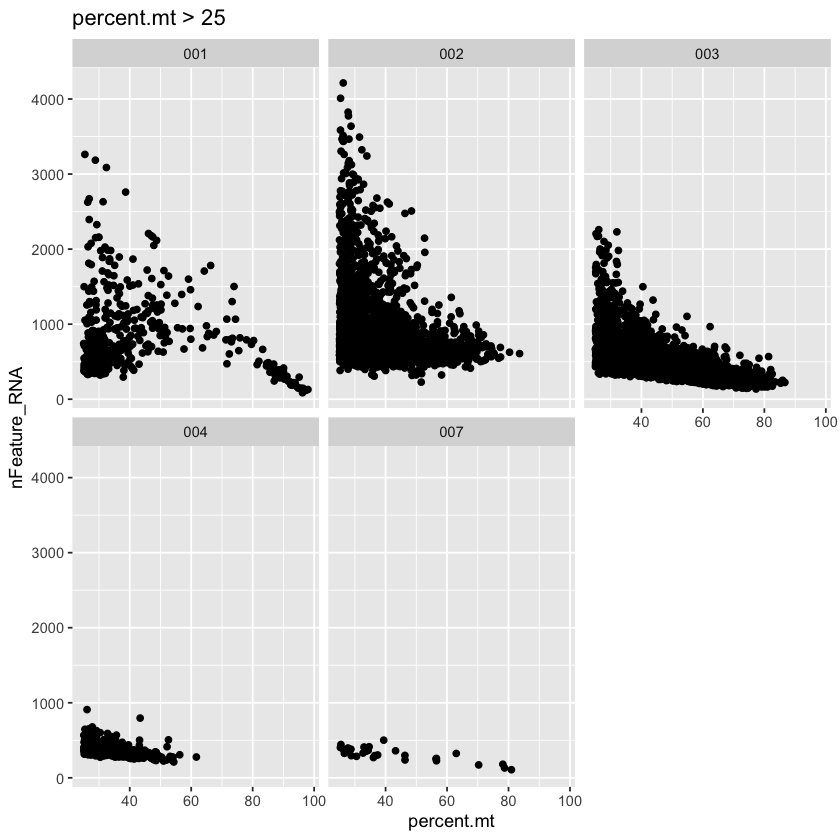

In [12]:
feature_tbl %>%
    filter(`percent.mt` > 25) %>%
    ggplot(aes(x=`percent.mt`, y=`nFeature_RNA`)) +
        geom_point() +
        facet_wrap(~`sample_id`) +
        labs(
            title='percent.mt > 25'
        )

In [13]:
feature_tbl %>%
    filter(`percent.mt` > 25) %>%
    summary()

  sample_id           cell_id           nFeature_RNA      nCount_RNA   
 Length:7320        Length:7320        Min.   :  86.0   Min.   :  500  
 Class :character   Class :character   1st Qu.: 381.0   1st Qu.:  913  
 Mode  :character   Mode  :character   Median : 572.0   Median : 1259  
                                       Mean   : 662.3   Mean   : 1599  
                                       3rd Qu.: 739.0   3rd Qu.: 1782  
                                       Max.   :4214.0   Max.   :14392  
   percent.mt   
 Min.   :25.01  
 1st Qu.:30.75  
 Median :39.46  
 Mean   :43.20  
 3rd Qu.:53.96  
 Max.   :97.98  

In [14]:
system.time({
    
    obs_006 %<>%
        subset(subset=(nFeature_RNA > 1000) & (percent.mt < 5)) %>%
        NormalizeData(
            normalization.method="LogNormalize",
            scale.factor=10000
        ) %>%
        FindVariableFeatures(
            selection.method="vst",
            nfeatures=2000
        ) %>%
        ScaleData %>%
        RunPCA(., features=VariableFeatures(object=.)) %>%
        RunUMAP(dims=1:10)
    
})

Centering and scaling data matrix

PC_ 1 
Positive:  SERPINE2, MIA, S100A13, APOD, IER3, S100B, S100A16, IFI27, TM4SF1, PMEL 
	   S100A1, NRG3, GPNMB, BACE2, C11orf96, DCBLD2, TSC22D1, FMN1, ATOX1, PLEKHA5 
	   NRP2, CTSB, KAZN, FBXL7, CD63, GPC6, PHLDA2, LGALS3, LSAMP, CDH19 
Negative:  MT-CO2, MT-ATP6, MT-CO1, MT-CO3, MT-ND3, MT-ND4, MT-CYB, IL32, GZMA, THEMIS 
	   MT-ND2, DOCK8, ARHGAP15, SKAP1, ITGA4, MT-ND1, MT-ND4L, NKG7, CCL5, SOS1 
	   ARHGDIB, IQGAP2, BCL2, SLFN12L, LTB, MT-ND5, CHST11, IKZF1, RNF213, ITGAL 
PC_ 2 
Positive:  SERPING1, IGFBP7, APOE, FN1, LRMDA, FCGRT, COL4A2, CTSL, TMEM176B, CAVIN1 
	   CXCL2, STARD13, COL4A1, MGP, CEBPD, TNFAIP2, COL18A1, VCAN, COL6A2, HSPA1B 
	   IGFBP4, ABCA1, PLXDC2, SOCS3, SELENOM, BGN, APP, APOC1, C1R, HSPA1A 
Negative:  HIST1H4C, S100A6, ISG20, MGST1, PAPPA2, TMEM233, PAGE5, HIST1H1C, PLEKHA5, TUBA1B 
	   TSPAN8, NRG3, HMGA1, HMGN2, RGS7, TYMS, FABP5, S100A16, ITIH5, TMEM147 
	   CNPY2, ROBO2, SPRR2D, DYNLT3, KCNQ5, MKI67, ENTHD1, TOP2A

   user  system elapsed 
171.020  37.507 185.259 

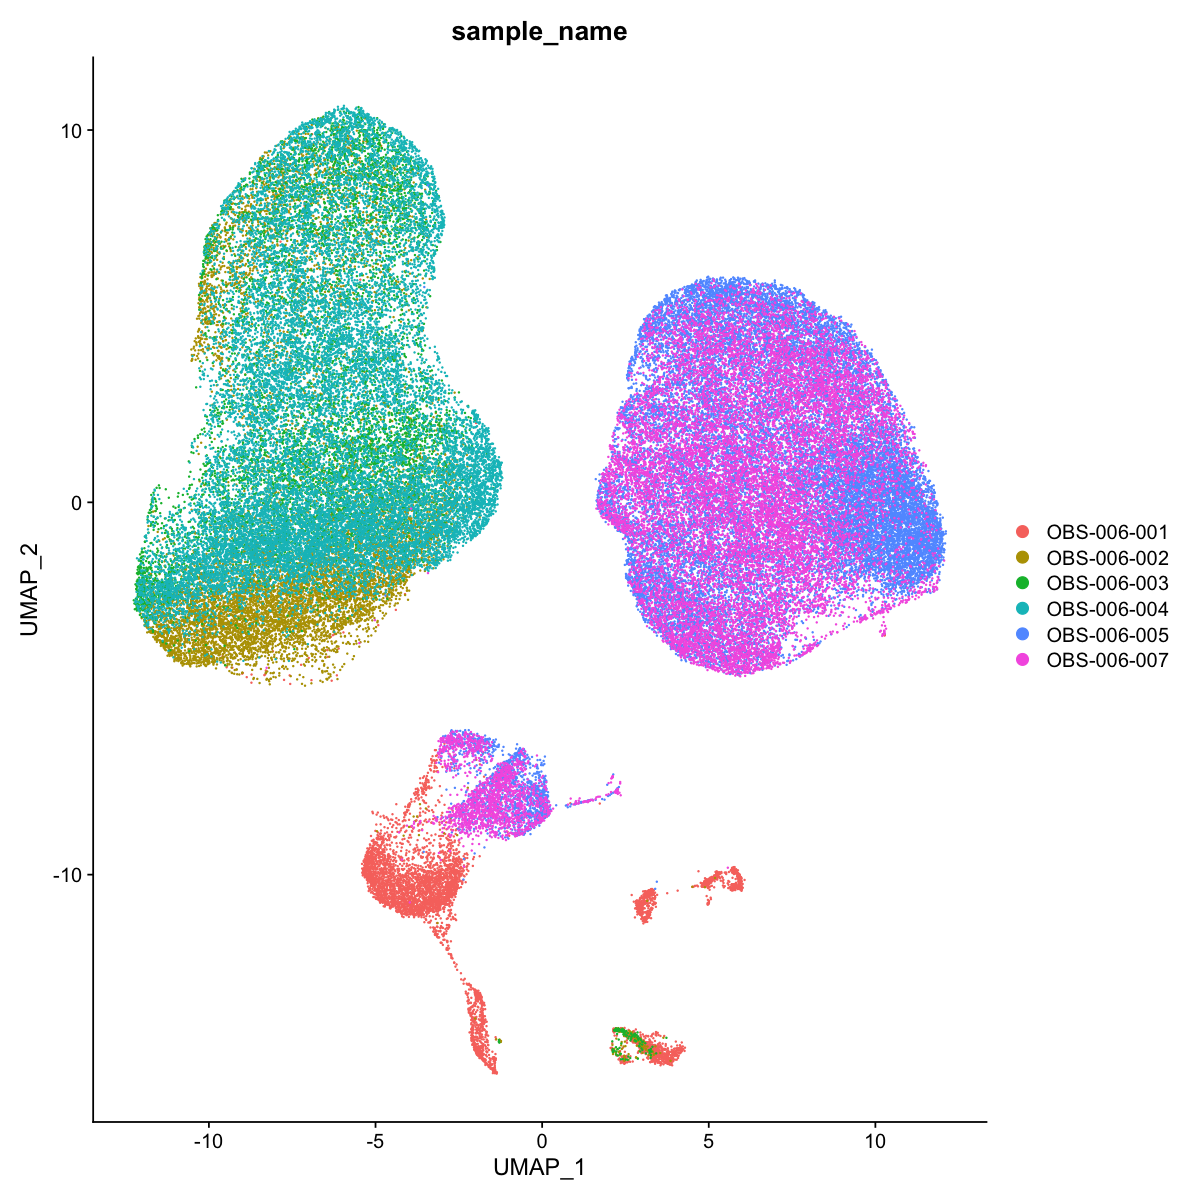

In [15]:
options(repr.plot.width=10, repr.plot.height=10)

sample_umap_plot <-
    DimPlot(obs_006, reduction="umap", group.by='sample_name')

sample_umap_plot

options(org_opts)

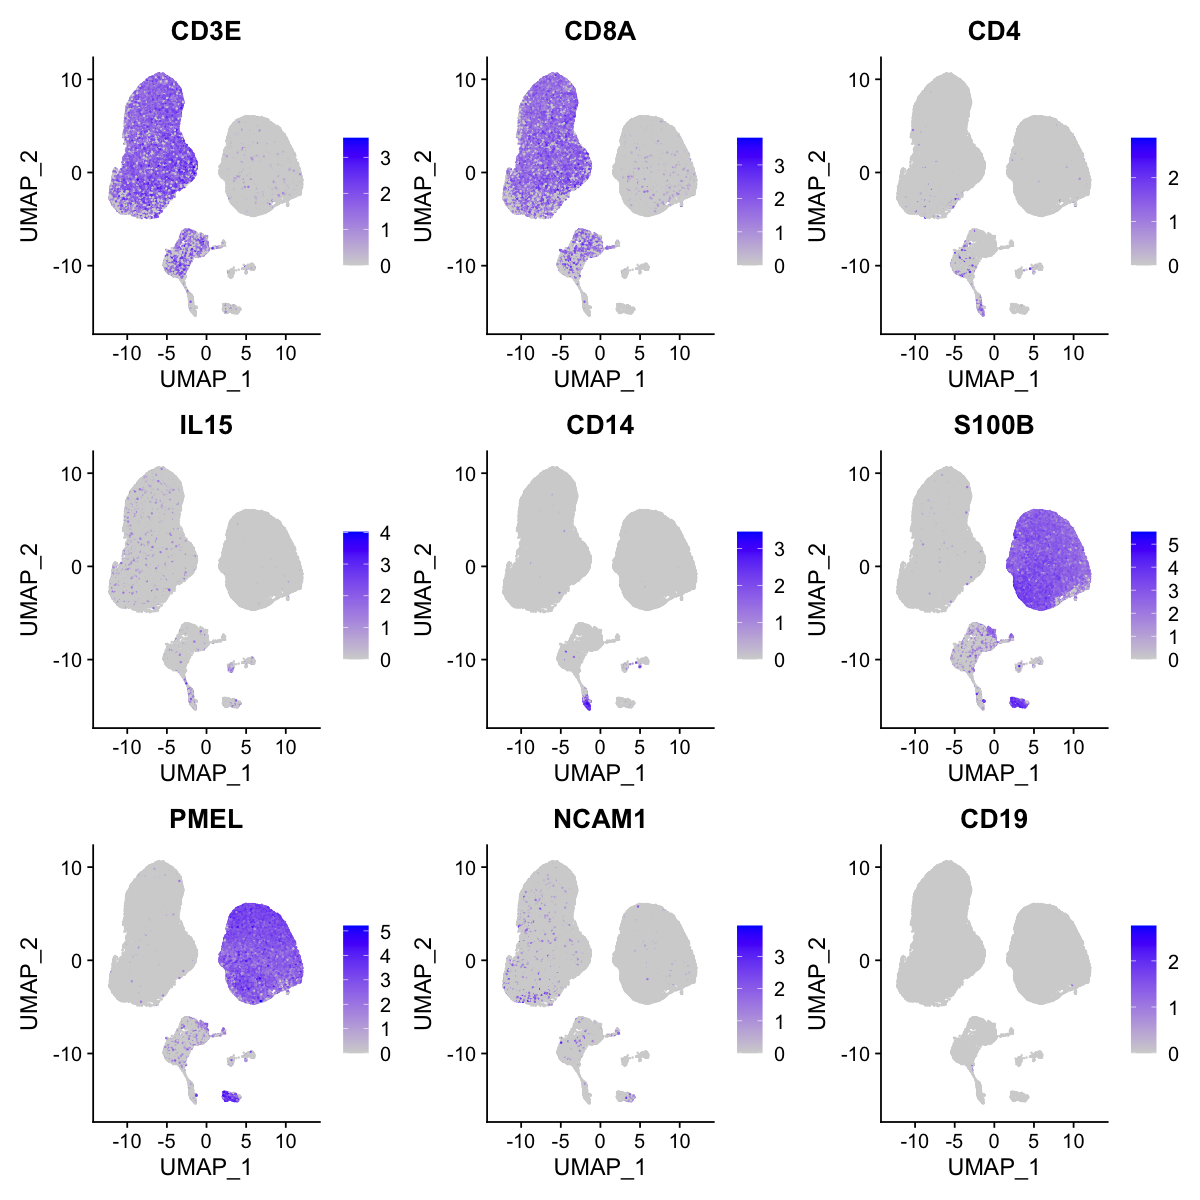

In [16]:
options(repr.plot.width=10, repr.plot.height=10)

FeaturePlot(obs_006, features=marker_genes)

options(org_opts)

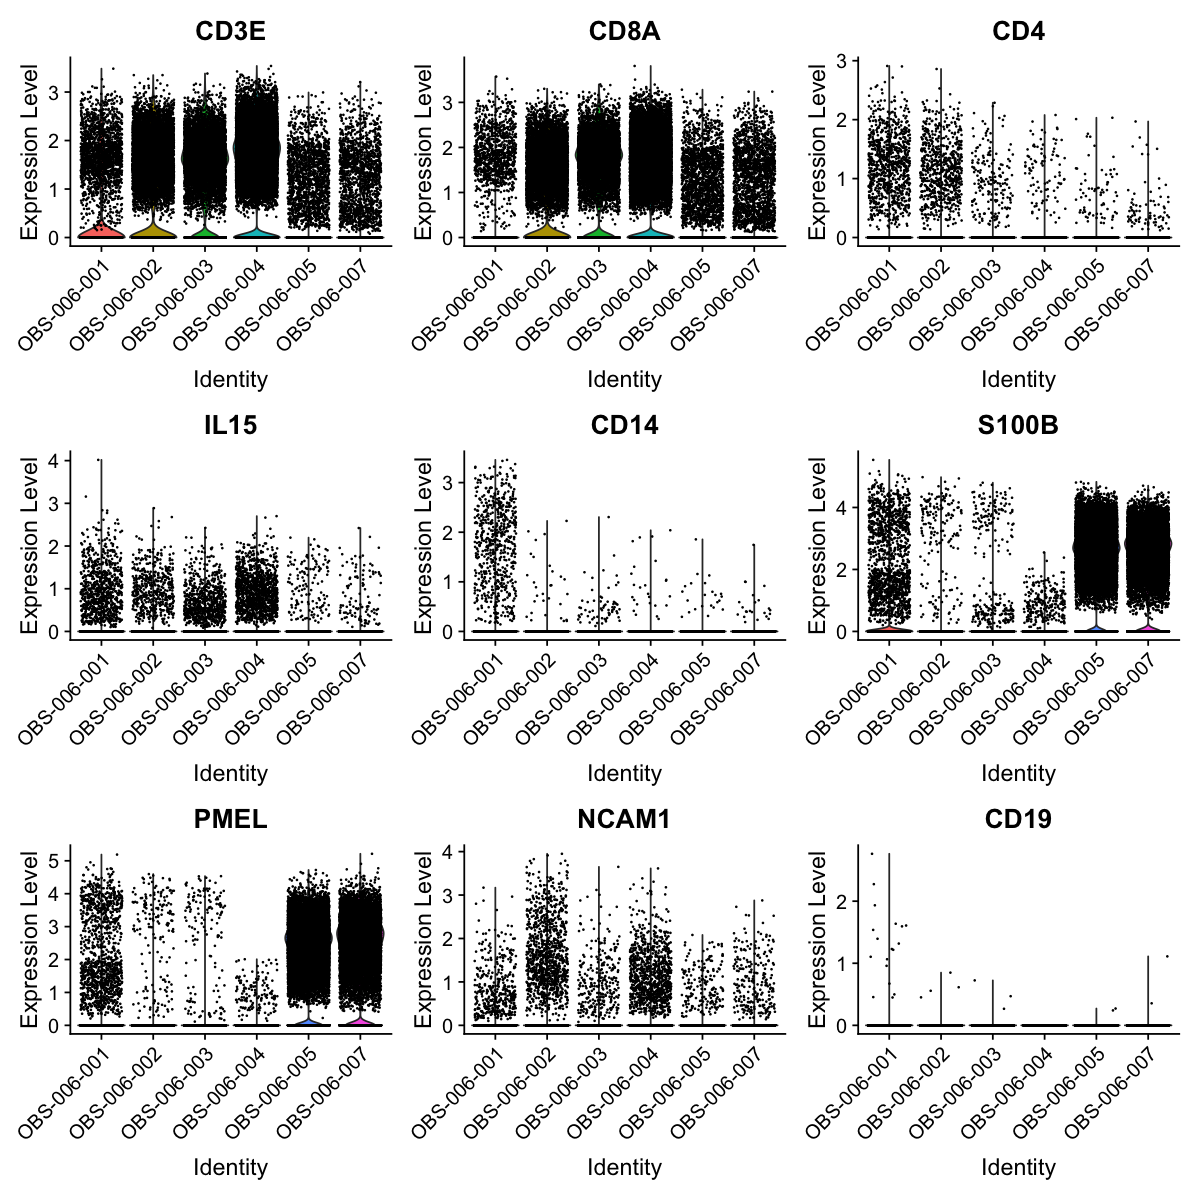

In [17]:
options(repr.plot.width=10, repr.plot.height=10)

VlnPlot(obs_006, features=marker_genes)

options(org_opts)

In [18]:
obs_006 %<>%
    FindNeighbors(dims=1:10) %>%
    FindClusters(resolution=0.5)

obs_006[["complete_cluster_id"]] <- Idents(obs_006)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 84641
Number of edges: 2589637

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9138
Number of communities: 15
Elapsed time: 23 seconds


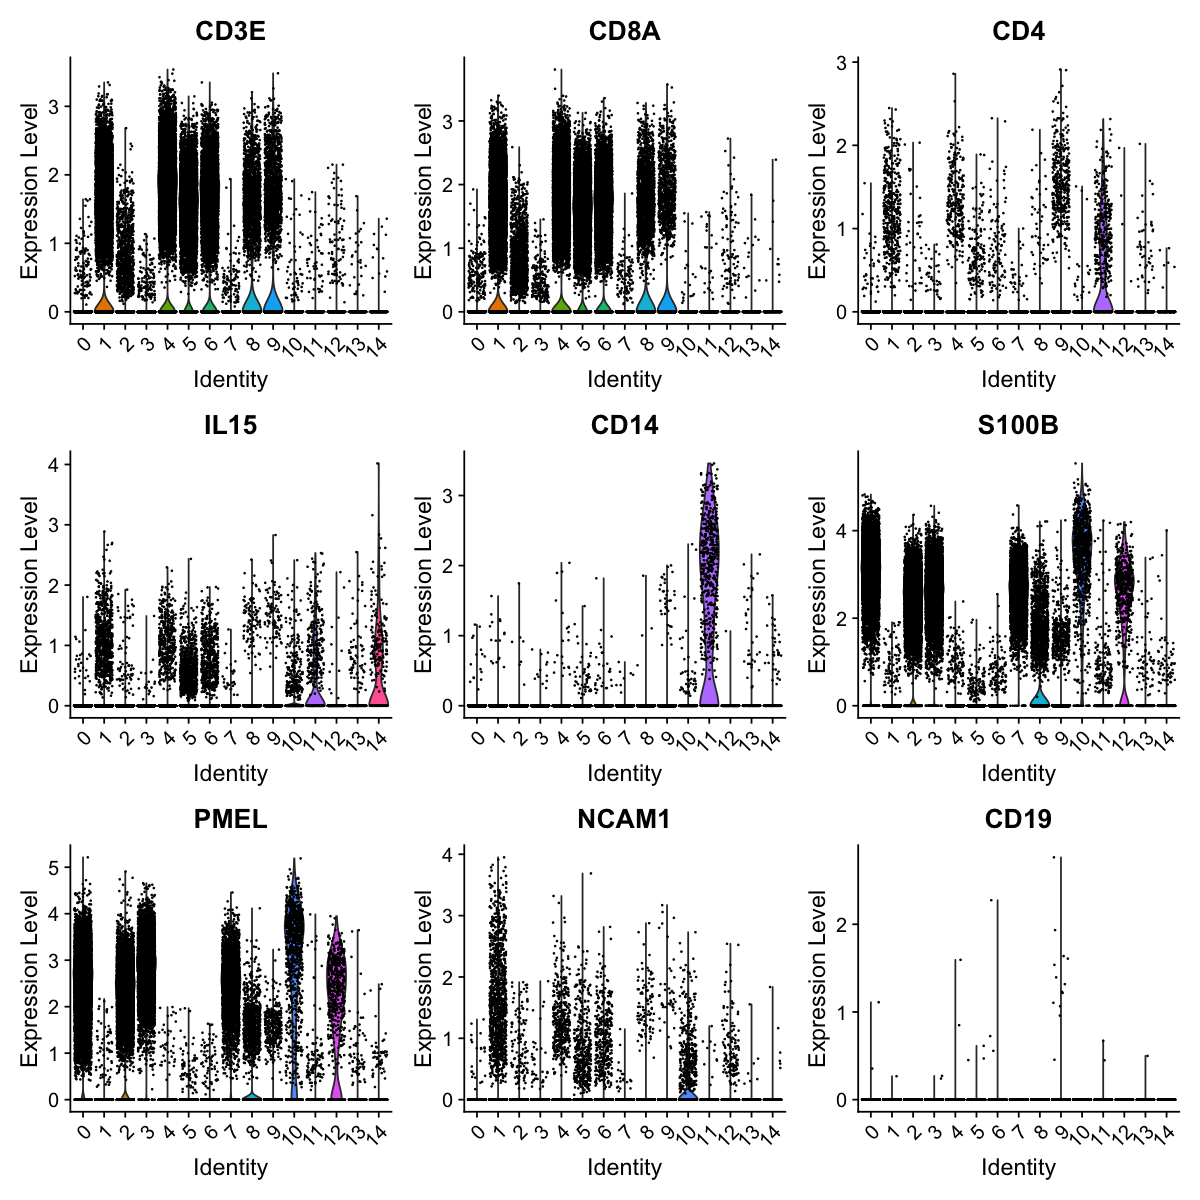

In [19]:
options(repr.plot.width=10, repr.plot.height=10)

VlnPlot(obs_006, features=marker_genes)

options(org_opts)

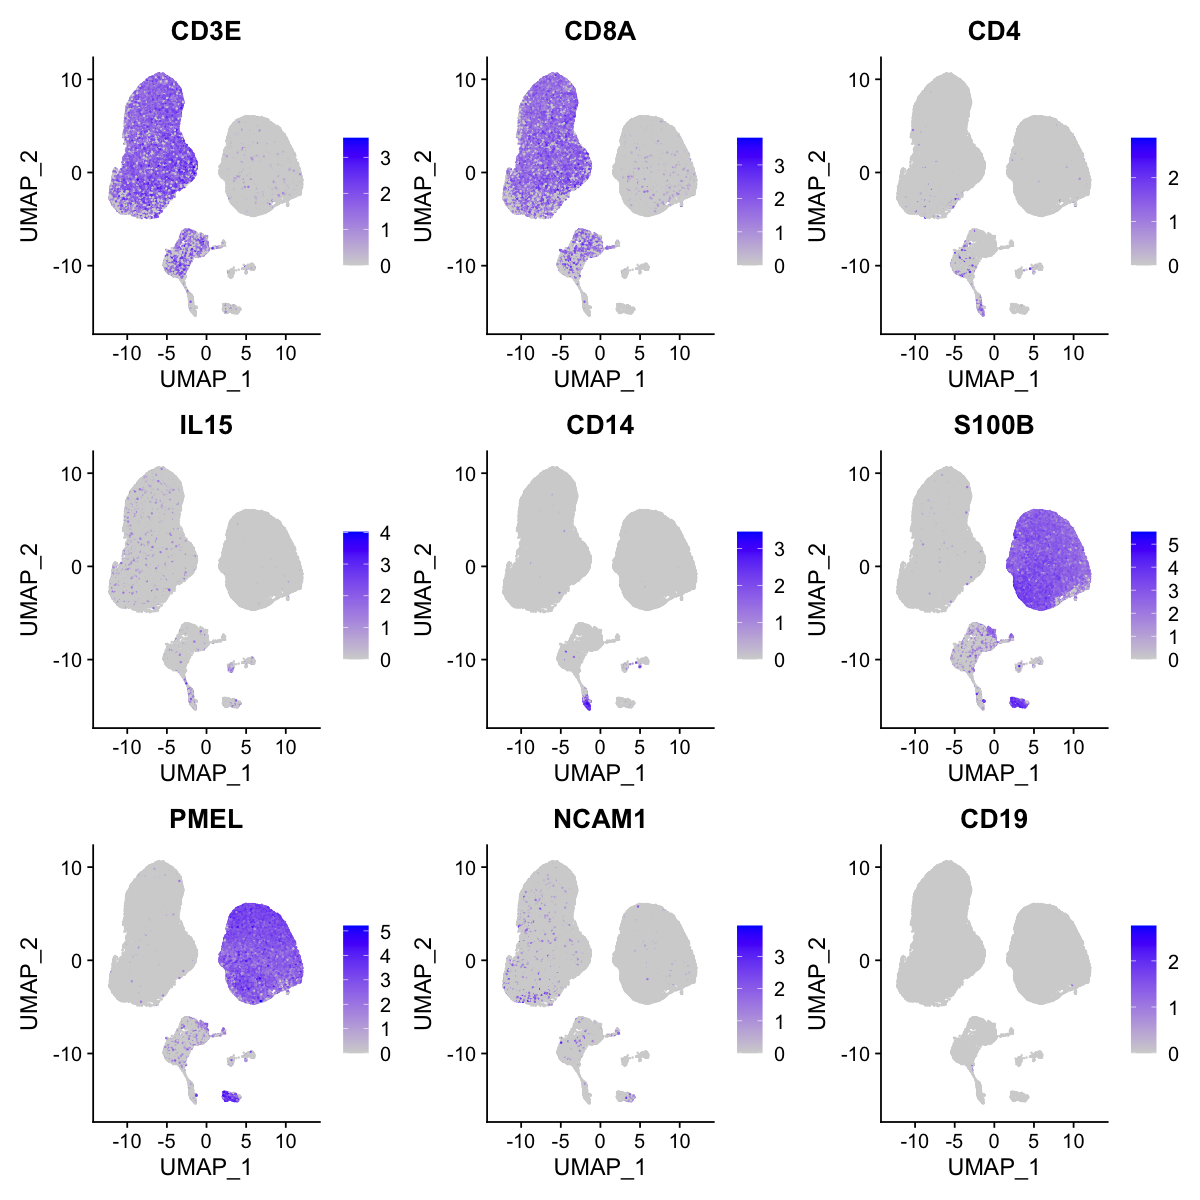

In [20]:
options(repr.plot.width=10, repr.plot.height=10)

sample_feature_umap_plot <-
    FeaturePlot(obs_006, features=marker_genes)

sample_feature_umap_plot

options(org_opts)

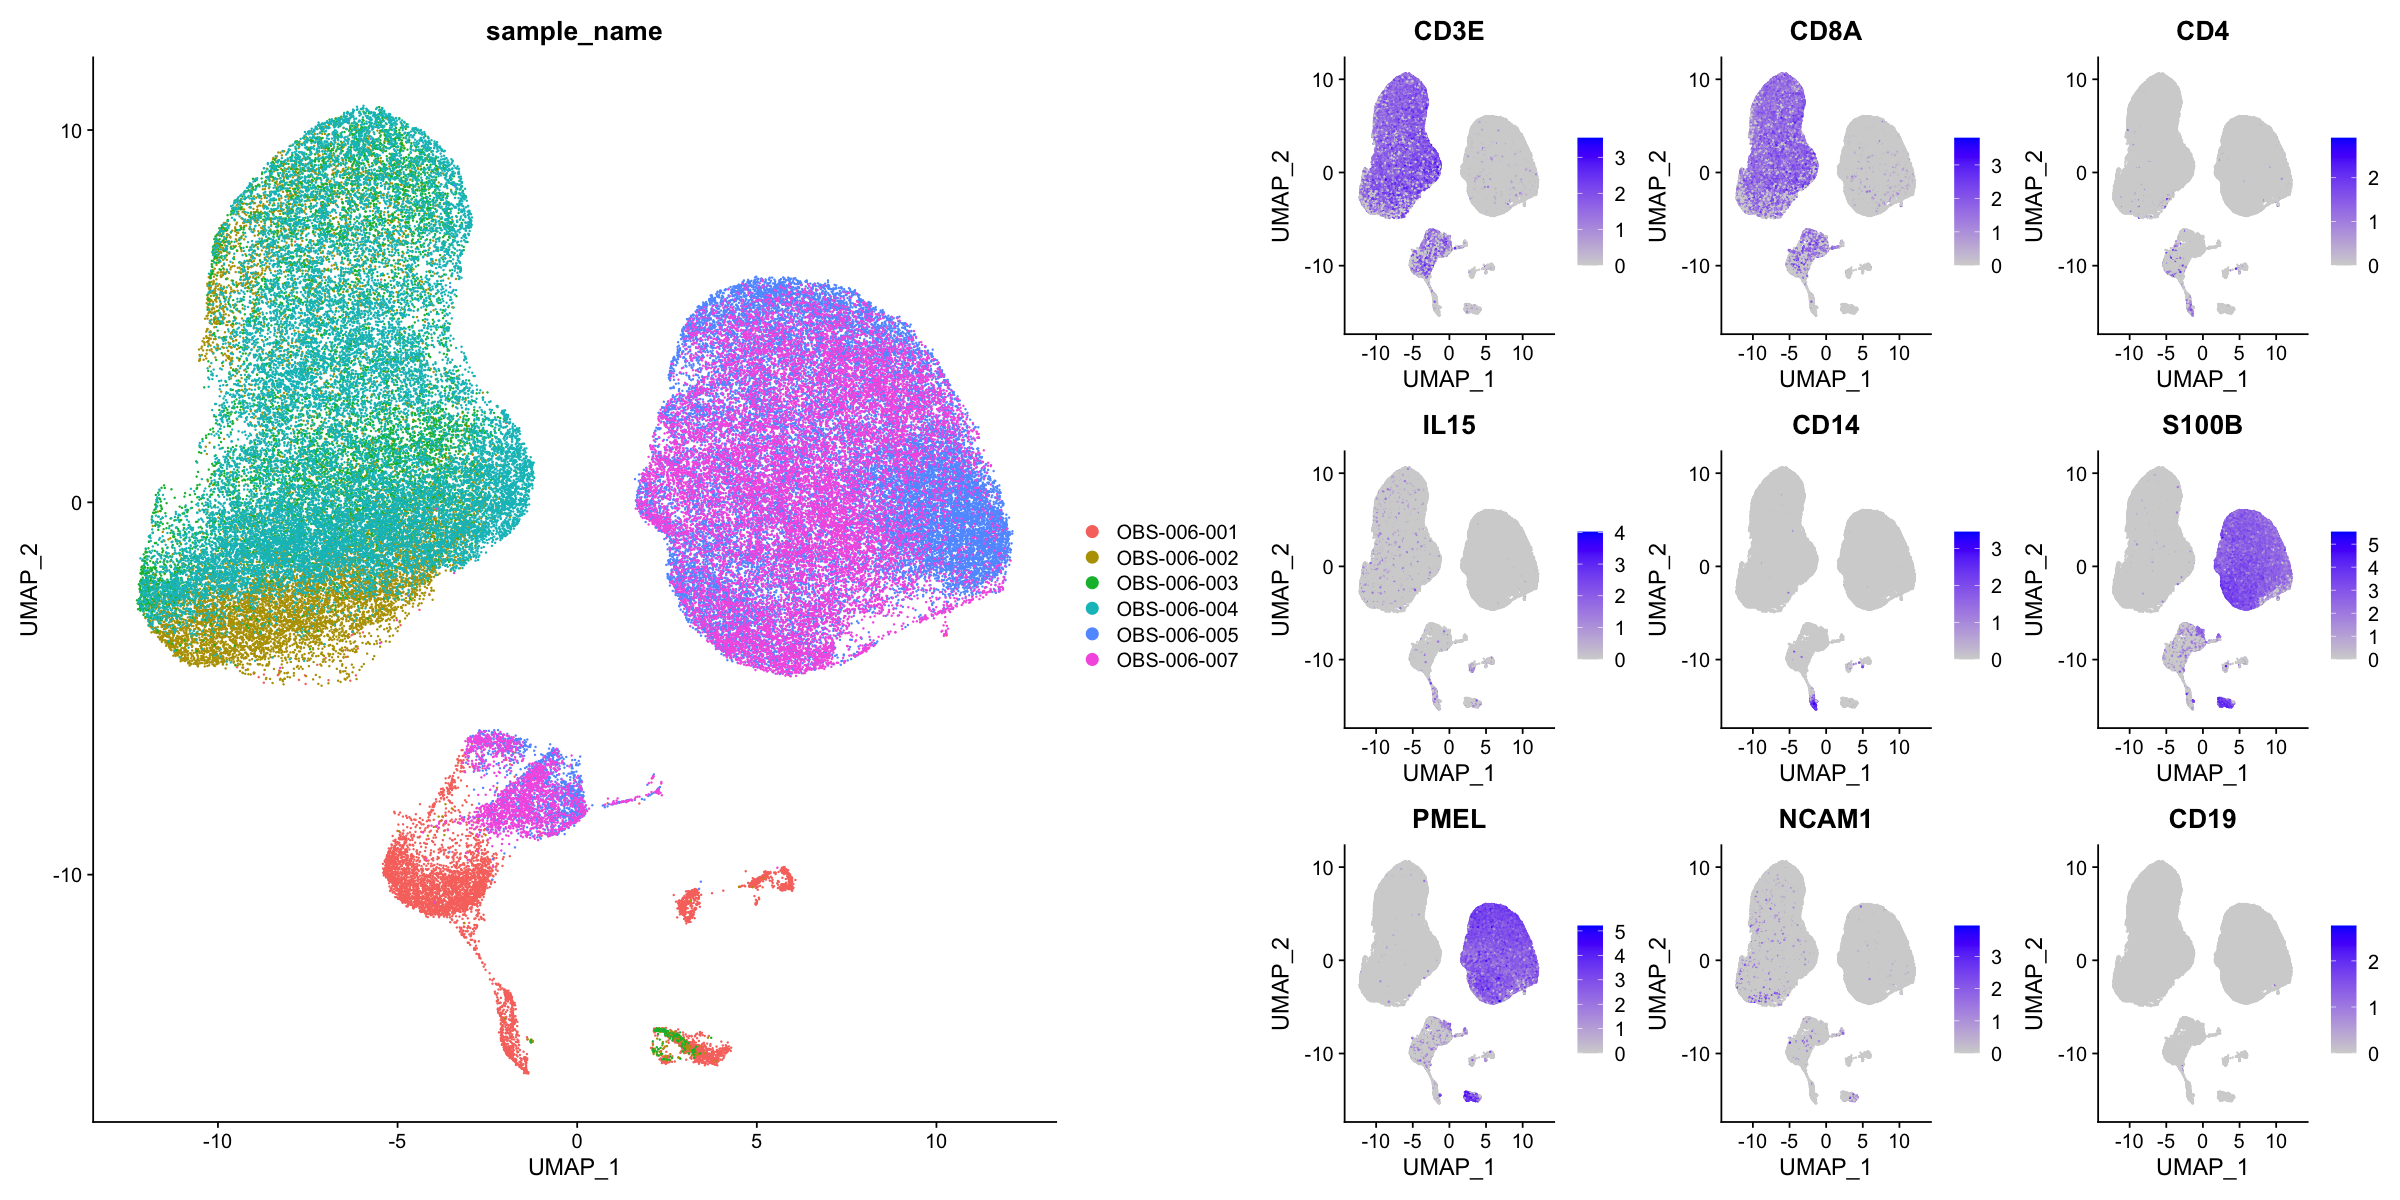

In [21]:
options(repr.plot.width=20, repr.plot.height=10)

sample_umap_plot + sample_feature_umap_plot

options(org_opts)

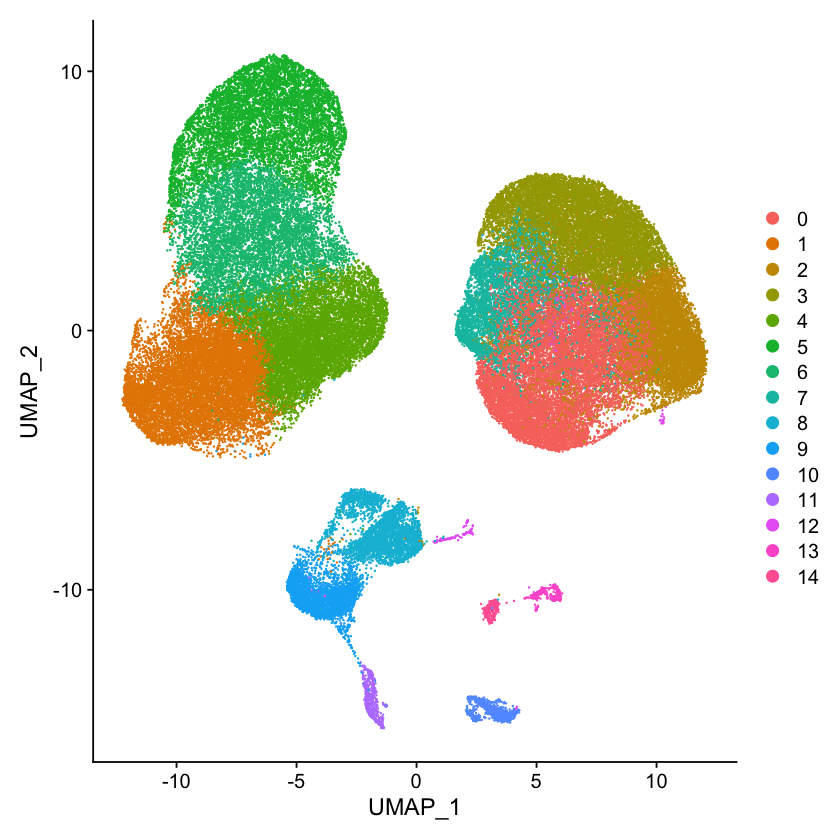

In [22]:
DimPlot(obs_006, reduction="umap")

In [23]:
exp_data <-
    FetchData(object=obs_006, vars=marker_genes) %>%
    rownames_to_column('cell_id') %>%
    mutate(`sample_id`=str_replace(`cell_id`, '_.*', '')) %>%
    as_tibble

exp_data %>%
    head()


cell_id                CD3E     CD8A     CD4      IL15     CD14 S100B   
1 001_AAACCCAAGCCAGACA-1 0.000000 0.000000 0.000000 0.000000 0    0.000000
2 001_AAACCCACACGCTGCA-1 0.000000 0.000000 0.000000 1.658896 0    0.000000
3 001_AAACCCAGTAGGTCAG-1 1.902537 2.256993 0.000000 0.000000 0    0.000000
4 001_AAACCCATCAGCTAGT-1 0.000000 0.000000 1.642228 0.000000 0    0.000000
5 001_AAACCCATCCTCACTG-1 0.000000 0.000000 0.000000 0.000000 0    0.000000
6 001_AAACGAAAGCTAGAAT-1 0.000000 0.000000 0.000000 0.000000 0    1.677751
  PMEL     NCAM1 CD19 sample_id
1 0.000000 0     0    001      
2 0.000000 0     0    001      
3 0.000000 0     0    001      
4 0.000000 0     0    001      
5 0.000000 0     0    001      
6 3.449179 0     0    001

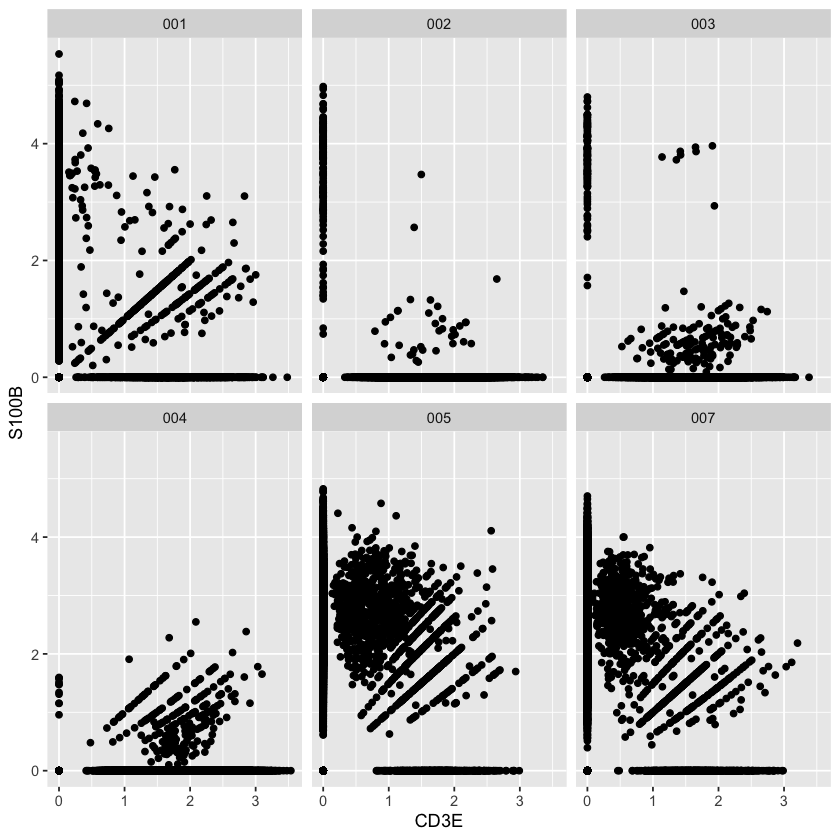

In [24]:
exp_data %>%
    ggplot(aes(x=`CD3E`, y=`S100B`)) +
        geom_point() +
        facet_wrap(~`sample_id`)

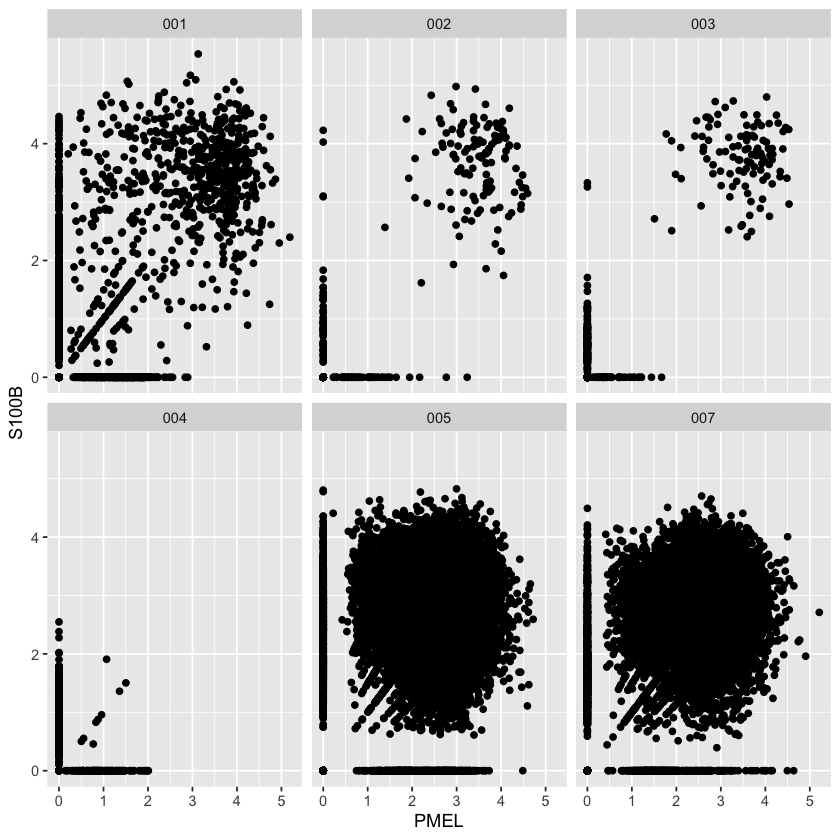

In [25]:
exp_data %>%
    ggplot(aes(x=`PMEL`, y=`S100B`)) +
        geom_point() +
        facet_wrap(~`sample_id`)

In [26]:
exp_data %>%
    mutate(
        `cell_category`=case_when(
            `PMEL` > exp_thold & `S100B` < exp_strict_thold ~ 'PMEL-pos',
            `PMEL` < exp_strict_thold & `S100B` > exp_thold ~ 'S100B-pos',
            `PMEL` > exp_thold & `S100B` > exp_thold ~ '++',
            `PMEL` < exp_strict_thold & `S100B` < exp_strict_thold ~ '--'
        )
    ) %>%
    count(`sample_id`, `cell_category`)

sample_id cell_category n    
1  001       --             3528
2  001       ++              690
3  001       PMEL-pos        443
4  001       S100B-pos       661
5  001       NA               76
6  002       --             9794
7  002       ++              127
8  002       PMEL-pos         40
9  002       S100B-pos        39
10 002       NA               20
11 003       --             6561
12 003       ++              106
13 003       PMEL-pos         23
14 003       S100B-pos        95
15 003       NA               72
16 004       --            19968
17 004       ++                8
18 004       PMEL-pos        116
19 004       S100B-pos       197
20 004       NA               64
21 005       --              808
22 005       ++            22910
23 005       PMEL-pos        516
24 005       S100B-pos      1112
25 005       NA                2
26 007       --              844
27 007       ++            14801
28 007       PMEL-pos        393
29 007       S100B-pos       612
30 007       NA               15

In [27]:
exp_data %>%
    mutate(
        `cell_category`=case_when(
            `CD3E` > exp_thold & `S100B` < exp_strict_thold ~ 'T cell',
            `CD3E` < exp_strict_thold & `S100B` > exp_thold ~ 'Tumor',
            `CD3E` > exp_thold & `S100B` > exp_thold ~ '++',
            `CD3E` < exp_strict_thold & `S100B` < exp_strict_thold ~ '--'
        )
    ) %>%
    count(`sample_id`, `cell_category`)

sample_id cell_category n    
1  001       --             2454
2  001       ++              285
3  001       T cell         1524
4  001       Tumor          1050
5  001       NA               85
6  002       --             2300
7  002       ++               28
8  002       T cell         7531
9  002       Tumor           138
10 002       NA               23
11 003       --              553
12 003       ++               99
13 003       T cell         6022
14 003       Tumor           102
15 003       NA               81
16 004       --             2634
17 004       ++              194
18 004       T cell        17463
19 004       Tumor            11
20 004       NA               51
21 005       --              855
22 005       ++              953
23 005       T cell          469
24 005       Tumor         22872
25 005       NA              199
26 007       --              648
27 007       ++              674
28 007       T cell          589
29 007       Tumor         14507
30 007       NA              247

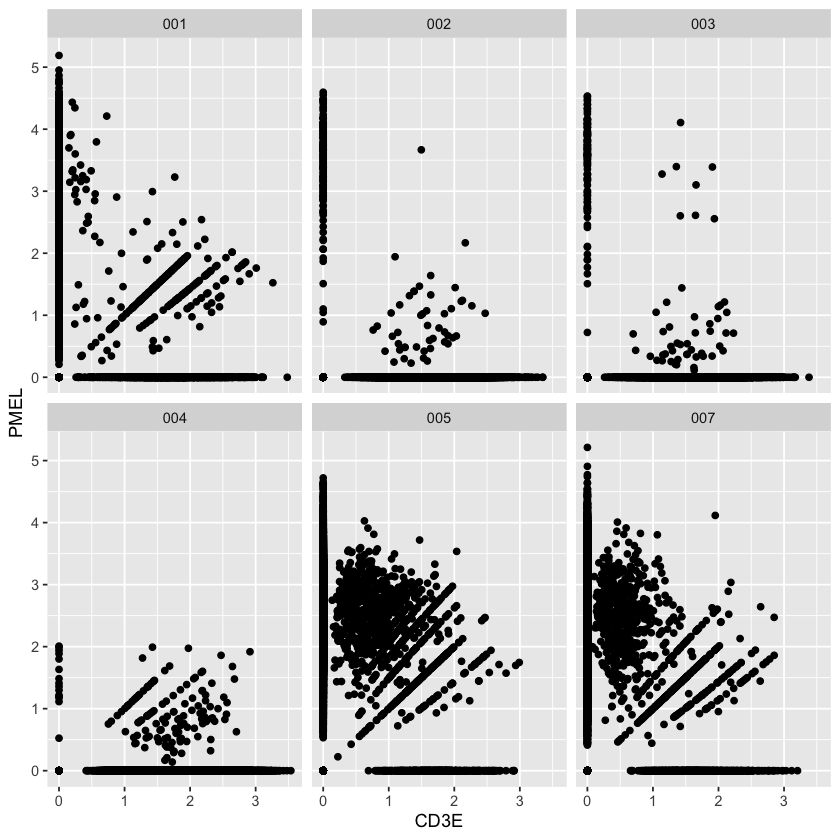

In [28]:
exp_data %>%
    ggplot(aes(x=`CD3E`, y=`PMEL`)) +
        geom_point() +
        facet_wrap(~`sample_id`)

In [29]:
# Cells shouldn't express these two genes at the same time

obs_006 <-
    subset(
        obs_006,
        (`CD3E` < exp_strict_thold) | (`PMEL` < exp_strict_thold)
    )

In [30]:
saveRDS(
    object=obs_006,
    file='processed_data/obs_006.Rdata'
)

In [31]:
obs_006_t_cells <-
    subset(
        obs_006,
        (`CD3E` > exp_thold) &
            (`PMEL` < exp_strict_thold) &
            (`S100B` < exp_strict_thold) &
            (`NCAM1` < exp_strict_thold)
    )

In [32]:
obs_006_t_cells[["sample_name"]] %>%
    table()

.
OBS-006-001 OBS-006-002 OBS-006-003 OBS-006-004 OBS-006-005 OBS-006-007 
       1348        6760        5740       16493         379         423 

In [33]:
tibble(
    `sample_name`=paste('OBS-006-00', c(1, 2, 3, 4, 5, 7), sep=''),
    `cell_cnt`=obs_006[["sample_name"]] %>% table(),
    `t_cell_cnt`=obs_006_t_cells[["sample_name"]] %>% table(),
) %>%
    mutate(`fraction-t_cell`=`t_cell_cnt`/`cell_cnt`)

sample_name cell_cnt t_cell_cnt fraction-t_cell
1 OBS-006-001  5143     1348      0.26210383     
2 OBS-006-002  9972     6760      0.67789811     
3 OBS-006-003  6806     5740      0.84337349     
4 OBS-006-004 20226    16493      0.81543558     
5 OBS-006-005 24311      379      0.01558965     
6 OBS-006-007 15851      423      0.02668601

In [34]:
saveRDS(
    object=obs_006_t_cells,
    file='processed_data/obs_006_t_cells.Rdata'
)